<a href="https://colab.research.google.com/github/alvitohawari/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-TensorFlow/blob/main/Chapter_14_deep_computer_vision_with_cnnss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**

_This notebook contains all the sample code in chapter 14._

# Setup

**Reading reference:** Chapter 14 (PDF pp. 1–3).

This section sets up the environment (imports, plotting helpers, and reproducibility settings) so the rest of the chapter’s CNN examples can run and be visualized consistently.


First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


A couple utility functions to plot grayscale and RGB images:

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

**Reading reference:** Chapter 14 — *Convolutional Layers* and the short note on convolution vs cross-correlation (PDF pp. 4–8).

The “convolution” used in deep learning libraries is typically **cross-correlation**:
- You slide a small kernel over the input and compute a weighted sum at each position.
- The main intuition (and what matters for CNNs) is that this operation detects local patterns repeatedly across the image.

The following cells build up that intuition before moving to full convolutional layers in Keras/TensorFlow.

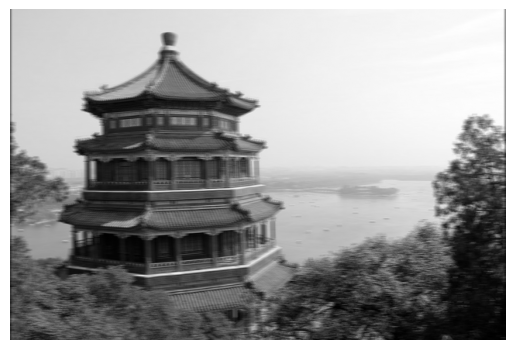

In [ ]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

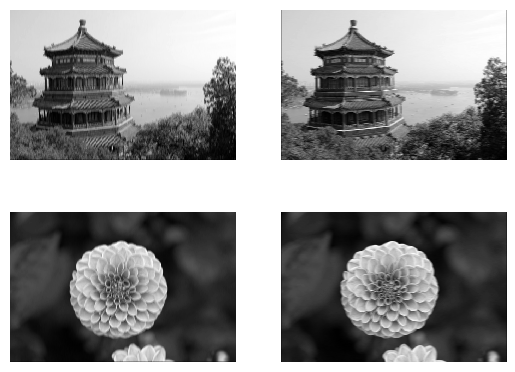

In [ ]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [ ]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


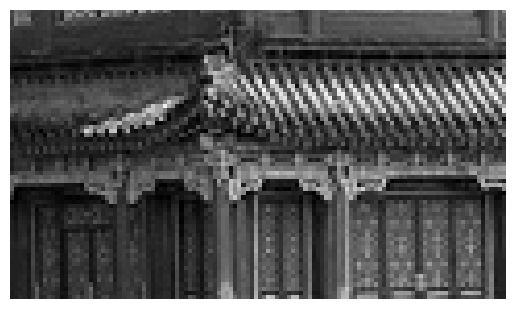

Saving figure china_vertical


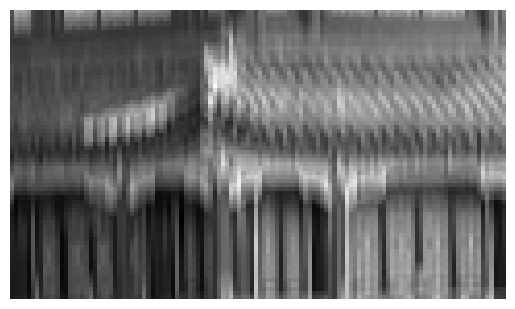

Saving figure china_horizontal


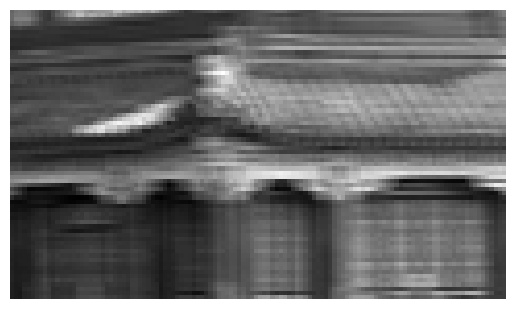

In [ ]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

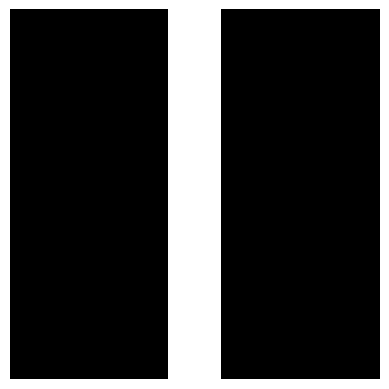

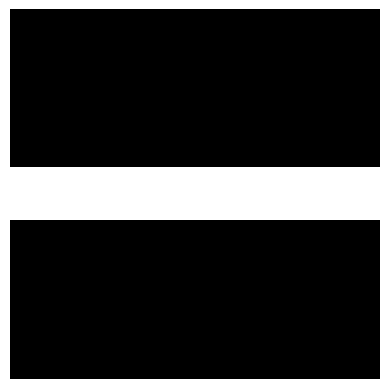

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layer

**Reading reference:** Chapter 14 — *Convolutional Layers* (PDF pp. 5–12).

A convolutional layer differs from a fully connected layer because it uses:
- **Local receptive fields**: each neuron looks only at a small patch of the input.
- **Shared weights (filters/kernels)**: the same small set of weights is slid across the image, producing a **feature map** that highlights where a pattern occurs.
- **Multiple filters**: each filter learns a different pattern, so the layer outputs multiple feature maps (a 3D volume: height × width × channels).

The code in this section implements these ideas by creating kernels/filters, applying them to images, and inspecting the resulting feature maps (exactly like the chapter’s filter/feature-map examples).

Let's create a 2D convolutional layer, using `keras.layers.Conv2D()`:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's call this layer, passing it the two test images:

In [ ]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since `padding="SAME"` and `strides=1`, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at the 2 output features maps for each image:

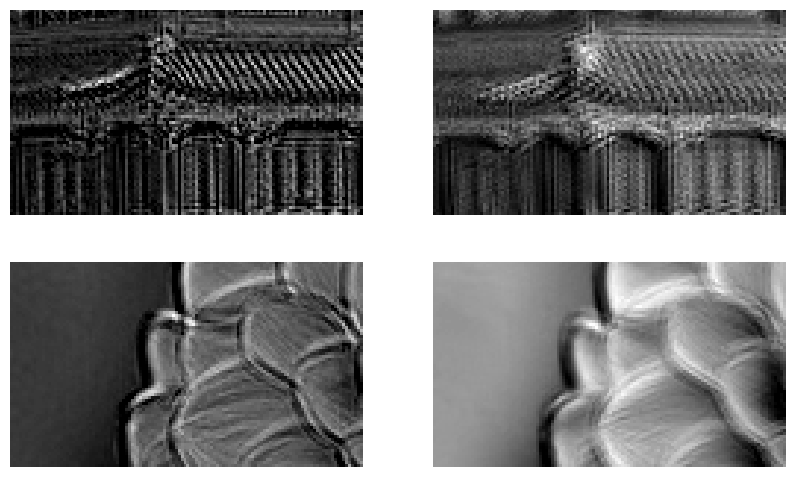

In [ ]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

Although the filters were initialized randomly, the second filter happens to act like an edge detector. Randomly initialized filters often act this way, which is quite fortunate since detecting edges is quite useful in image processing.

If we want, we can set the filters to be the ones we manually defined earlier, and set the biases to zeros (in real life we will almost never need to set filters or biases manually, as the convolutional layer will just learn the appropriate filters and biases during training):

In [ ]:
conv.set_weights([filters, np.zeros(2)])

Now let's call this layer again on the same two images, and let's check that the output feature maps do highlight vertical lines and horizontal lines, respectively (as earlier):

In [ ]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

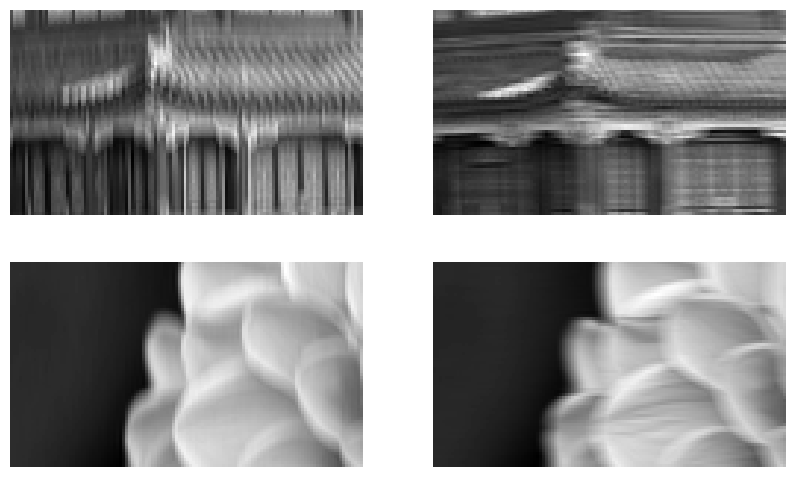

In [ ]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## VALID vs SAME padding

**Reading reference:** Chapter 14 — *Convolutional Layers* (Padding="SAME" vs "VALID") (PDF pp. 5–6).

This section explains the padding choice used in convolution code:
- **"SAME" padding** adds zeros around the borders when needed so the output spatial size is roughly the input size divided by stride (and equals the input size when stride=1).
- **"VALID" padding** adds no padding, so the convolution is computed only where the kernel fully fits inside the image; the output is smaller.

The notebook’s experiments illustrate how padding changes output shapes and border behavior.

In [ ]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [ ]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [ ]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

In [ ]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Pooling layer

**Reading reference:** Chapter 14 — *Pooling Layers* (PDF pp. 13–16).

Pooling layers are introduced as a way to:
- Reduce **spatial resolution**, cutting computation/memory and helping control overfitting.
- Provide limited **translation/scale/rotation invariance** (especially with max pooling), which can be beneficial for classification tasks.

The notebook’s pooling sections implement these ideas using Keras layers and small examples to show how outputs change after pooling.

## Max pooling

**Reading reference:** Chapter 14 — *Pooling Layers* (Max pooling) (PDF pp. 14–15).

Max pooling is used to **downsample** feature maps:
- With a 2×2 window and stride 2, each output keeps only the maximum activation from its window, shrinking height and width by ~2×.
- This reduces computation and memory, and introduces some **invariance to small translations**—useful for classification.
- The chapter also highlights a key caveat: pooling is destructive and can hurt tasks that require precise spatial output (where you want equivariance, not invariance).

In the notebook, `MaxPool2D` demonstrates the standard layer described in the text.

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [ ]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


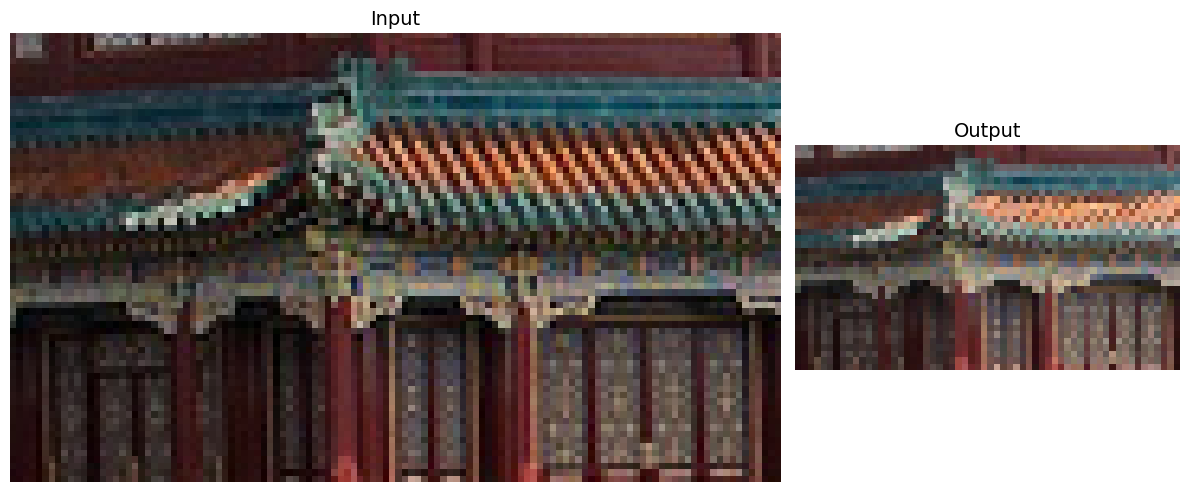

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## Depth-wise pooling

**Reading reference:** Chapter 14 — *Pooling Layers* (Depthwise pooling)  (PDF pp. 16).

Depthwise pooling aggregates across the **channel/feature-map dimension** instead of across height/width:
- The chapter’s motivation is invariance: if multiple channels detect variations of the same pattern (e.g., different rotations), depthwise max pooling can keep the strongest response regardless of variation.
- Keras does not provide a dedicated depthwise max pooling layer, so the chapter suggests using TensorFlow’s low-level `tf.nn.max_pool()` with kernel/stride configured to pool along the depth dimension, and wrapping it in a `Lambda` layer when needed.

The notebook’s code reflects that exact implementation strategy.

In [ ]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [ ]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Or just use a `Lambda` layer:

In [ ]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

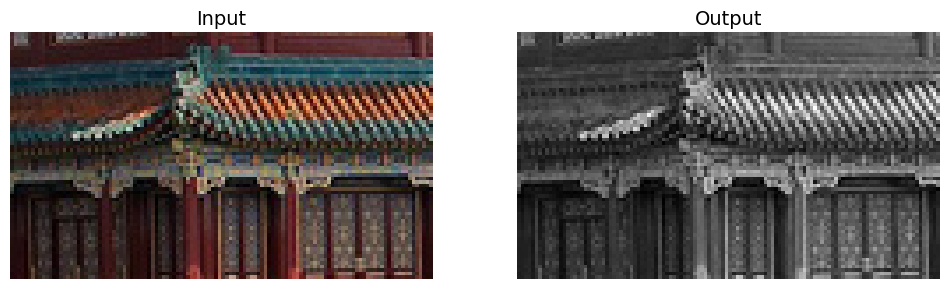

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Average pooling

**Reading reference:** Chapter 14 — *Pooling Layers* (Average Pooling) (PDF pp. 15–16).

Average pooling works like max pooling, except it **computes the mean** in each pooling window:
- Historically it was popular, but the chapter notes that **max pooling often performs better** because it keeps the strongest activations and can provide stronger translation invariance.
- You still choose the same key hyperparameters: pooling window size, stride, and padding.

This explains why the notebook demonstrates both variants and how they differ in the signal they pass to the next layers.

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [ ]:
output_avg = avg_pool(cropped_images)

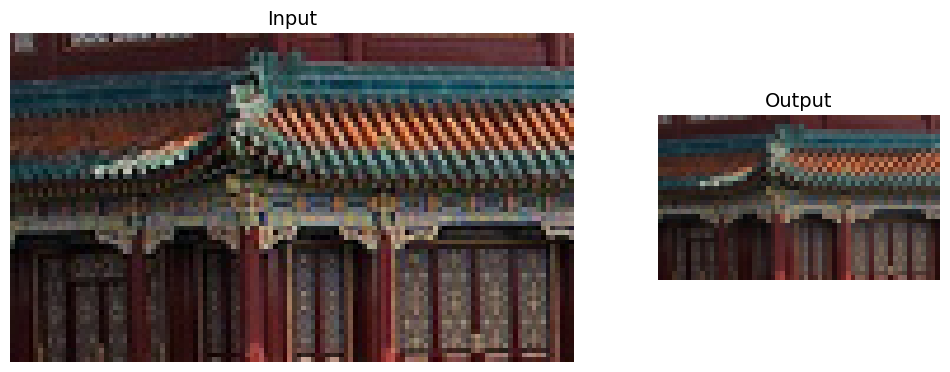

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global Average Pooling

**Reading reference:** Chapter 14 — *Pooling Layers* (Global Average Pooling) (PDF pp. 16) and examples in later architectures (e.g., GoogLeNet).

Global Average Pooling compresses each feature map into **one number** by averaging over all spatial positions:
- It removes most spatial information, but keeps *which features are present*.
- It is commonly used near the output for classification, reducing the need for large dense layers and helping reduce overfitting.

In the notebook, the layer plays the same role described in the chapter: a lightweight bridge from convolutional feature maps to a final classifier.

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.45952484, 0.3342377 ]], dtype=float32)>

In [ ]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.45952484, 0.3342377 ]], dtype=float32)>

# Tackling Fashion MNIST With a CNN

**Reading reference:** Chapter 14 — *CNN Architectures* (PDF pp. 17–22).


This Fashion-MNIST model follows the chapter’s “classic CNN recipe”:
- Stack **convolution + ReLU** blocks to learn local patterns, then add **pooling** occasionally to reduce spatial resolution and computation.
- It’s common to **increase the number of filters** as resolution decreases (often doubling after pooling), because higher layers can represent many combinations of lower-level features.
- After feature extraction, you **flatten** and use **dense layers** for final classification; dropout is added to reduce overfitting.

The chapter also notes a practical rule of thumb: prefer multiple **3×3** convolutions over a single large kernel (often fewer parameters and better performance), except sometimes in the very first layer.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 746s 431ms/step - accuracy: 0.6224 - loss: 1.0504 - val_accuracy: 0.8546 - val_loss: 0.4149
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 736s 428ms/step - accuracy: 0.8419 - loss: 0.4771 - val_accuracy: 0.8754 - val_loss: 0.3483
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 728s 423ms/step - accuracy: 0.8665 - loss: 0.3977 - val_accuracy: 0.8860 - val_loss: 0.3187
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 730s 425ms/step - accuracy: 0.8810 - loss: 0.3563 - val_accuracy: 0.8924 - val_loss: 0.2957
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 743s 425ms/step - accuracy: 0.8887 - loss: 0.3282 - val_accuracy: 0.8948 - val_loss: 0.3117
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 733s 427ms/step - accuracy: 0.8959 - loss: 0.3137 - val_accuracy: 0.8902 - val_loss: 0.3058
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 728s 423ms/step - accuracy: 0.8949 - loss: 0.3067 - val_accuracy: 0.8896 - val_loss: 0.3053
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 736s 420ms/step - ac

## ResNet-34

**Reading reference:** Chapter 14 — *ResNet* and *Implementing a ResNet-34 CNN Using Keras* (PDF pp. 27–35).

The notebook’s ResNet-34 implementation matches the chapter’s residual-learning idea:
- A **skip connection** adds the input of a residual unit to its output, so the unit learns a *residual* (a correction) rather than a full transformation. This helps optimization in very deep networks.
- A standard residual unit uses **two 3×3 convolutions** with Batch Normalization and ReLU (the chapter shows this as the basic building block).
- When the spatial size is reduced (stride 2) and the number of feature maps increases, the shortcut path must be adjusted with a **1×1 convolution (stride 2)** so the shapes match before addition.

So the code here is an implementation of the chapter’s “residual unit + many repeats” architecture that made deep CNNs much easier to train.

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 28, 28, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 14, 14, 256)    │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 7, 7, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,306,826 (81.28 MB)

 Trainable params: 21,289,802 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

## Using a Pretrained Model

**Reading reference:** Chapter 14 — *Using Pretrained Models from Keras* (PDF pp. 36–39).

This part of the notebook applies a ready-made vision model from `keras.applications`:
- The chapter explains that pretrained models expect a **specific input size** (e.g., 224×224 for ResNet-50), so the code resizes images accordingly.
- It also emphasizes that models require **architecture-specific preprocessing** (hence `preprocess_input()`), because each model was trained with a particular input scaling/convention.
- After prediction, `decode_predictions()` is used to turn the raw probability vector into **human-readable top-K classes**.

Conceptually, this code is the “plug-and-play” path: *load → resize → preprocess → predict → decode*.

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


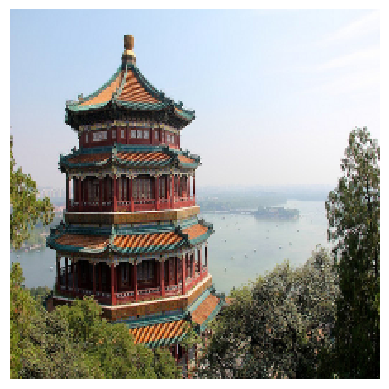

In [ ]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

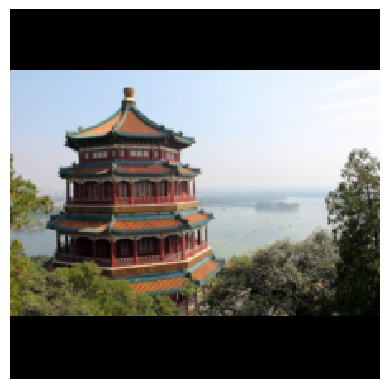

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

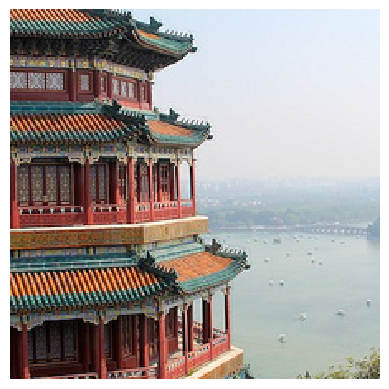

In [ ]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

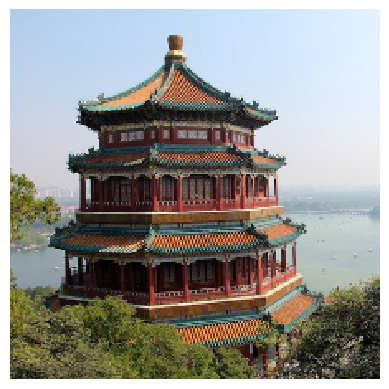

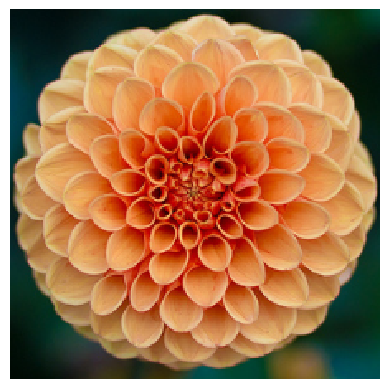

In [ ]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
Y_proba.shape

(2, 1000)

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



## Pretrained Models for Transfer Learning

**Reading reference:** Chapter 14 — *Pretrained Models for Transfer Learning* (PDF pp. 36–39).

This section’s code shows *transfer learning* with a pretrained CNN:
- You load a pretrained backbone (e.g., Xception) and **exclude the classification head** (`include_top=False`), then add your own pooling + dense classifier for your dataset.
- You **resize and preprocess** images exactly as the pretrained model expects (the book notes that each architecture has its own `preprocess_input()`).
- You typically **freeze the pretrained layers first**, train the new top layers, then **unfreeze** (some or all) layers and continue training with a **much smaller learning rate** to avoid damaging pretrained weights.
- Optional **data augmentation** (random crops/flips/etc.) is used as a regularization technique to reduce overfitting.

In short: the code implements the chapter’s recommended workflow—*reuse general visual features learned on ImageNet, then adapt them to a new classification task*.

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.AR8CC1_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info.splits

{Split('train'): <SplitInfo num_examples=3670, num_shards=2>}

In [ ]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [ ]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

**Warning:** TFDS's split API has evolved since the book was published. The [new split API](https://www.tensorflow.org/datasets/splits) (called S3) is much simpler to use:

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

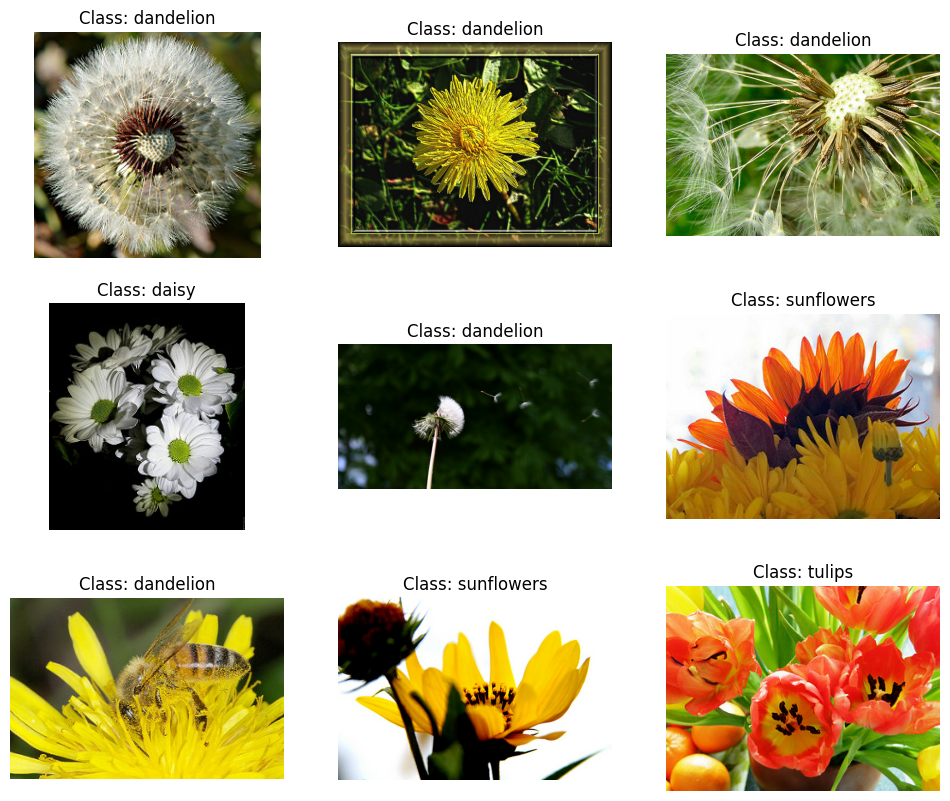

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Basic preprocessing:

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

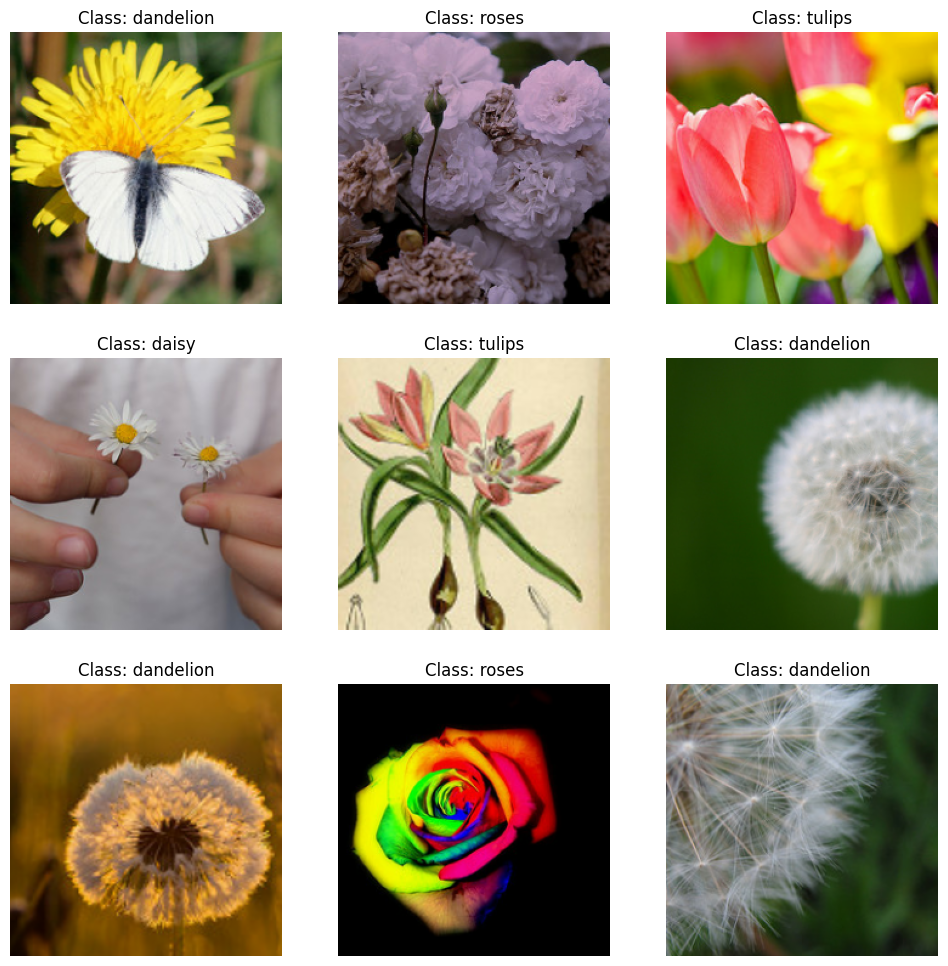

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

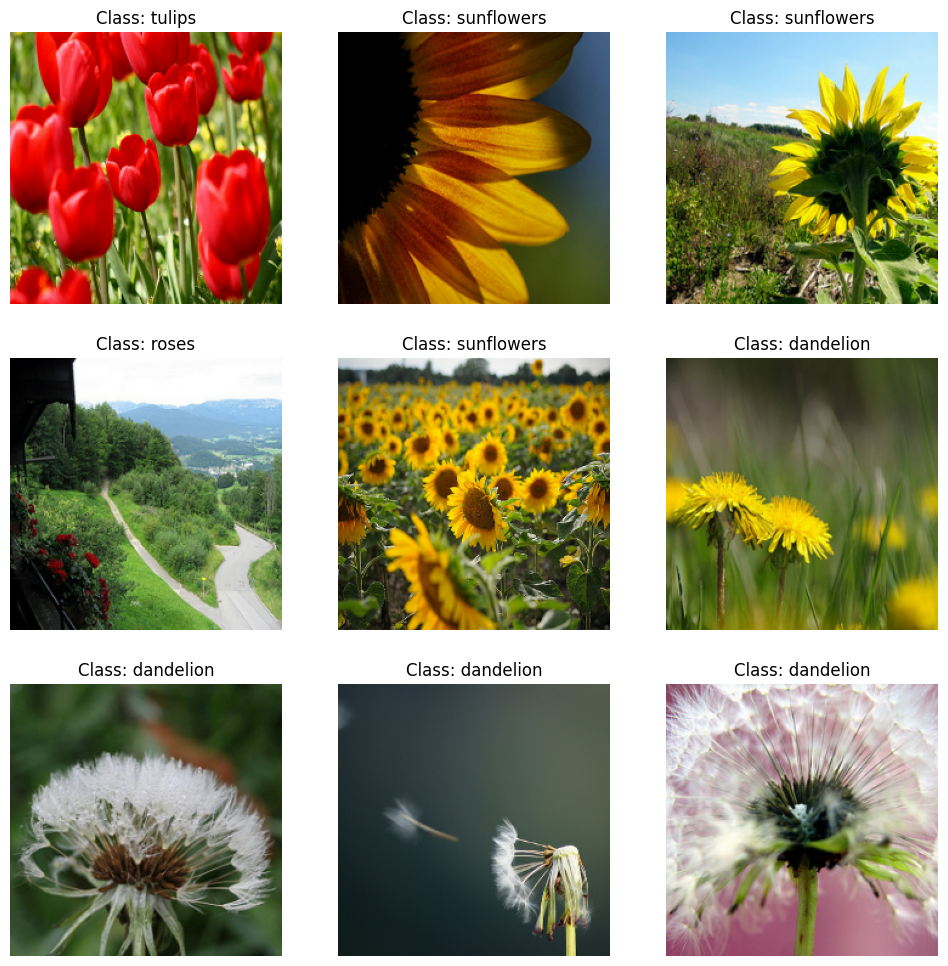

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_layer_4
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_45
13 block2_pool
14 batch_normalization_37
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_46
23 block3_pool
24 batch_normalization_38
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_47
33 block4_pool
34 batch_normalization_39
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 690s 8s/step - accuracy: 0.7254 - loss: 1.3049 - val_accuracy: 0.8548 - val_loss: 1.0522
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 675s 8s/step - accuracy: 0.8828 - loss: 0.7617 - val_accuracy: 0.8548 - val_loss: 1.2085
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 681s 8s/step - accuracy: 0.8960 - loss: 0.7208 - val_accuracy: 0.8603 - val_loss: 1.3983
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 683s 8s/step - accuracy: 0.9220 - loss: 0.4707 - val_accuracy: 0.8309 - val_loss: 1.4294
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 668s 8s/step - accuracy: 0.9157 - loss: 0.4960 - val_accuracy: 0.8438 - val_loss: 1.4842


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 2553s 29s/step - accuracy: 0.8399 - loss: 0.5439 - val_accuracy: 0.8419 - val_loss: 0.5083
Epoch 2/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 2473s 29s/step - accuracy: 0.9534 - loss: 0.1429 - val_accuracy: 0.9081 - val_loss: 0.2965
Epoch 3/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 2486s 29s/step - accuracy: 0.9774 - loss: 0.0721 - val_accuracy: 0.9210 - val_loss: 0.2311
Epoch 4/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 2542s 30s/step - accuracy: 0.9793 - loss: 0.0704 - val_accuracy: 0.9136 - val_loss: 0.2977
Epoch 5/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 2543s 30s/step - accuracy: 0.9860 - loss: 0.0478 - val_accuracy: 0.9081 - val_loss: 0.2889
Epoch 6/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 2542s 30s/step - accuracy: 0.9913 - loss: 0.0241 - val_accuracy: 0.9136 - val_loss: 0.3103
Epoch 7/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 2541s 30s/step - accuracy: 0.9891 - loss: 0.0369 - val_accuracy: 0.9099 - val_loss: 0.3002
Epoch 8/40
86/86 ━━━━━━━━━━━━━━━━━━━━ 2496s 29s/step - accuracy: 0.9865 - loss: 0.0387 - val_accu